# Monte Carlo Simulation
## Author: Snigdhayan Mahanta

I created a sample supply chain network. The network consists of a few `tiers`; each organization belongs to a tier and has a (potentially empty) list of `suppliers` and `customers`. In each tier a few organizations compete against each other to procure materials form the organizations in the previous tier and supply to the organizations in the next tier. A `demand` parameter controls the rate at which they purchase and supply. The financial performances of the companies are measured in terms of `capital`, `expense` and `revenue`. The network can be created flexibly and visualized via `NetworkX`. I used `tensorflow probability` to perform `Monte Carlo Simulation` and to compute the expected profit margin of the entire network based on varying demand.

In [1]:
import networkx as nx
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions

In [2]:
# Class definition of 'Organization'
class Organization:
    '''
    An organization's performance is measured by its capital, expense and revenue
    
    '''
    
    def __init__(self, tier, id, capital, expense, revenue, suppliers, customers):
        self.tier = tier
        self.id = id
        self.capital = capital
        self.expense = expense
        self.revenue = revenue
        self.suppliers = suppliers
        self.customers = customers

    
    @property
    def label(self):
        return "T"+str(self.tier)+"_O"+str(self.id)
        # return (self.tier, self.id)
    
    @property
    def profit_margin(self):
        if np.all((self.revenue > 0)): return (self.revenue - self.expense)/self.revenue
        if np.all((self.revenue <= 0)): return None
    
    @property
    def turnover_ratio(self):
        if np.all((self.capital > 0)): return (self.revenue/self.capital)
        if np.all((self.capital <= 0)): return None
    
    def get_tier(self):    
        return self.tier
    
    def get_id(self):    
        return self.id
    
    def get_capital(self):    
        return self.capital
       
    def get_expense(self):    
        return self.expense
        
    def get_revenue(self):    
        return self.revenue
    
    def get_suppliers(self):    
        return self.suppliers
    
    def get_customers(self):    
        return self.customers
 
    def purchase(self, demand): # demand governs procurement
        for x in self.suppliers:
            amount = demand*x.capital
            if np.all((self.capital - amount >= 0)):
                self.capital += -amount
                self.expense += amount
                x.revenue += amount
            
    def operate(self, demand): # demand governs the change in the financial parameters
        if np.all((self.capital + demand*self.capital >= 0)): self.capital += demand*self.capital
        if np.all((self.expense + demand*self.expense >= 0)): self.expense += demand*self.expense
        if np.all((self.revenue + demand*self.revenue >= 0)): self.revenue += demand*self.revenue
            
    def supply(self, demand): # demand governs the supply
        for x in self.customers:
            amount = demand*x.revenue
            self.revenue += amount
            x.expense += amount
             
    def add_supplier(self, organization):
        self.suppliers.append(organization)
        
    def add_customer(self, organization):
        self.customers.append(organization)

In [3]:
# Utility functions to create a supply chain network
def create_tier(tier):
    size = np.random.choice(range(2, 4))
    tier_orgs = []
    for i in range(1, size+1):
        Capital = np.random.choice(a=range(1000, 100000)) # random initial capital
        Expense = np.random.choice(a=range(1000, 100000)) # random initial expense
        Revenue = np.random.choice(a=range(100, 10000)) # random initial revenue
        Suppliers = []
        Customers = []
        org = Organization(tier, i, Capital, Expense, Revenue, Suppliers, Customers)
        tier_orgs.append(org)
    return tier_orgs
        

def create_network(n_tiers):
    Network_orgs = []
    for i in range(n_tiers):
        tier = create_tier(i)
        Network_orgs.append(tier)
    
    Edges = []
    for j in range(n_tiers-1):
        customers = Network_orgs[j]
        suppliers = Network_orgs[j+1]
    
        for k in range(3, 5):
            source = np.random.choice(suppliers, replace = True)
            target = np.random.choice(customers, replace = True)
            pair = (source.label, target.label)
            Edges.append(pair) 
            source.add_customer(target) # create supplier-customer relationship
            target.add_supplier(source) # create customer-supplier relationship      
    
    Network_orgs = [item for sublist in Network_orgs for item in sublist]
    Edge_list = list(set(Edges))
    return Network_orgs, Edge_list

In [4]:
# Utility function to create a networkx directed graph
def create_directed_graph(edges):
    #edges = list(map(lambda x: tuple(x), Edges))
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    return graph

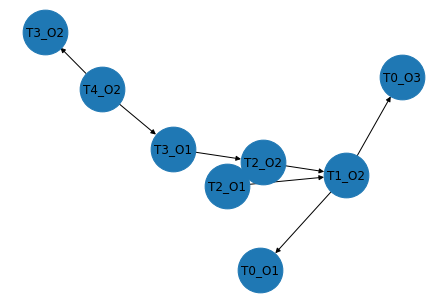

In [5]:
# Create and visualize a supply chain network
N_tiers = 5 # No. of tiers in the network
np.random.seed(7)
Organizations, Edges = create_network(N_tiers)
Graph = create_directed_graph(Edges)
#nx.draw_kamada_kawai(Graph, with_labels=True, node_size=2000)
nx.draw(Graph, pos=nx.spring_layout(Graph), with_labels=True, node_size=2000)

In [6]:
def printDict(dict):
    for key, value in dict.items(): print ("%s : %s"%(key, value))

In [7]:
# Rank the organizations by turnover ratio
org_labels = [org.label for org in Organizations]
turnover_ratios = [round(org.turnover_ratio, 2) for org in Organizations]
turnover_ratios = dict([t for t in zip(org_labels, turnover_ratios)])
turnover_ratios = {k: v for k, v in sorted(turnover_ratios.items(), key=lambda item: item[1], reverse = True)}
printDict(turnover_ratios)

T1_O2 : 3.72
T2_O2 : 2.13
T3_O2 : 0.55
T2_O3 : 0.19
T4_O1 : 0.14
T2_O1 : 0.13
T1_O1 : 0.12
T0_O1 : 0.1
T3_O1 : 0.1
T0_O3 : 0.08
T0_O2 : 0.03
T4_O2 : 0.02
T3_O3 : 0.01


In [8]:
# Rank the organizations by profit margin
# org_labels = [org.label for org in Organizations]
profit_margins = [round(org.profit_margin, 2) for org in Organizations]
profit_margins = dict([t for t in zip(org_labels, profit_margins)])
profit_margins = {k: v for k, v in sorted(profit_margins.items(), key=lambda item: item[1], reverse = True)}
printDict(profit_margins)

T3_O2 : -1.63
T2_O2 : -1.98
T3_O1 : -3.52
T2_O3 : -4.73
T2_O1 : -7.13
T0_O1 : -7.74
T4_O1 : -9.72
T1_O2 : -10.57
T1_O1 : -13.06
T0_O3 : -14.22
T0_O2 : -44.83
T4_O2 : -45.89
T3_O3 : -276.68


In [9]:
def one_round(organizations):
    for x in organizations:
        x.purchase(0.1)
        x.operate(0.1)
        x.supply(0.1)

In [10]:
for _ in range(10):
    one_round(Organizations)

In [11]:
# Rank the organizations by turnover ratio again
# org_labels = [org.label for org in Organizations]
turnover_ratios = [round(org.turnover_ratio, 2) for org in Organizations]
turnover_ratios = dict([t for t in zip(org_labels, turnover_ratios)])
turnover_ratios = {k: v for k, v in sorted(turnover_ratios.items(), key=lambda item: item[1], reverse = True)}
printDict(turnover_ratios)

T1_O2 : 68.61
T3_O2 : 17.99
T2_O2 : 5.77
T4_O2 : 1.97
T3_O1 : 1.09
T2_O1 : 0.37
T2_O3 : 0.19
T4_O1 : 0.14
T1_O1 : 0.12
T0_O1 : 0.1
T0_O3 : 0.08
T0_O2 : 0.03
T3_O3 : 0.01


In [12]:
# Rank the organizations by profit margin again
# org_labels = [org.label for org in Organizations]
profit_margins = [round(org.profit_margin, 2) for org in Organizations]
profit_margins = dict([t for t in zip(org_labels, profit_margins)])
profit_margins = {k: v for k, v in sorted(profit_margins.items(), key=lambda item: item[1], reverse = True)}
printDict(profit_margins)

T4_O2 : 0.63
T2_O2 : -1.5
T3_O1 : -1.72
T2_O1 : -1.89
T3_O2 : -4.39
T2_O3 : -4.73
T1_O2 : -5.18
T0_O1 : -8.87
T4_O1 : -9.72
T1_O1 : -13.06
T0_O3 : -15.38
T0_O2 : -44.83
T3_O3 : -276.68


In [13]:
# Define a function to compute the profit margin according to demand
def profit_margin_fn(demand):
    Orgs, Connections = create_network(N_tiers)
    for x in Orgs:
        x.purchase(demand)
        x.operate(demand)
        x.supply(demand)
    profit_margins = [org.profit_margin for org in Orgs]
    #return profit_margins[0] 
    return sum(profit_margins)/len(profit_margins)

In [14]:
# Use Monte Carlo simulation to compute the expected profit margin
N_tiers = 50 
num_draws = 10000
distn = tfd.Normal(loc=50.0, scale=5.0) # Demand is normally distributed
demands = distn.sample(num_draws, seed=42)/100
profit_margin_expectation = tfp.monte_carlo.expectation(
    profit_margin_fn, samples=demands, log_prob=None, use_reparameterization=True,
    use_reparametrization=True, axis=0, keepdims=False, keep_dims=False, name=None
)

# Print expected profit margin
profit_margin_expectation

<tf.Tensor: shape=(), dtype=float32, numpy=-8.63528>